In [ ]:
#@title Run this to download the data and setup the environment
import cv2
import dlib
import gdown
import pickle
import warnings
import itertools

import numpy as np
import pandas as pd
import seaborn as sns

import urllib.request

from sklearn import metrics
from sklearn.metrics import accuracy_score

from scipy.spatial import distance
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

###Getting the csv data loaded
!wget -q --show-progress -O ./ferdata.csv "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Emotion%20Detection/fer2013_5.csv"

###Getting the Dlib Shape predictor!
!wget -q --show-progress -O ./shape_predictor_68_face_landmarks.dat "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Emotion%20Detection/shape_predictor_68_face_landmarks.dat"

###Getting the Xpure loaded
!wget -q --show-progress -O ./pureX.npy "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Emotion%20Detection/pureX.npy"

###Getting the Xdata loaded
!wget -q --show-progress -O ./dataX.npy "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Emotion%20Detection/dataX.npy"

###Getting the Ydata loaded
!wget -q --show-progress -O ./dataY.npy "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Emotion%20Detection/dataY.npy"

print ("Data Downloaded!")


./ferdata.csv       100%[===================>] 159.97M   112MB/s    in 1.4s    
./shape_predictor_6 100%[===================>]  95.08M  84.9MB/s    in 1.1s    
./pureX.npy         100%[===================>]  43.95M   106MB/s    in 0.4s    
./dataX.npy         100%[===================>] 347.59M  34.4MB/s    in 5.6s    
./dataY.npy         100%[===================>] 156.38K  --.-KB/s    in 0.002s  
Data Downloaded!


### Dataset Background

We will use modified version of the fer2013 dataset consisting of five emotion labels.

The dataset is stored in a csvfile. Each row in the csvfile denotes an instance.
Every instance has two column attributes :

*   Pixels of the image stored in string format
*   Integer encoding of the target label

There are total of 20,000 images distributed equally across the five emotions. The images are 48\*48 grayscale cropped images. The csvfile consists of flattened arrays of each image stored in the form of a string.

The target labels are integers encoded in the csvfile. They are mapped as follows:

*   0 ---> Angry
*   1 ---> Happy
*   2 ---> Sad
*   3 ---> Surprise
*   4 ---> Neutral



In [ ]:
#Integer to Label Mapping
label_map = {0:"ANGRY",1:"HAPPY",2:"SAD",3:"SURPRISE",4:"NEUTRAL"}

#Load the data
df = pd.read_csv("./ferdata.csv")
df.head()

,emotion,pixels,Usage
0,0,215 216 215 215 215 216 216 216 214 178 81 30 ...,Training
1,4,244 244 244 244 243 244 242 190 132 93 81 73 7...,Training
2,4,255 255 255 255 255 255 255 255 255 255 255 25...,Training
3,4,38 56 60 52 58 65 53 44 35 48 59 60 36 30 21 3...,Training
4,4,77 40 27 21 22 25 20 31 27 17 27 42 47 55 51 4...,Training


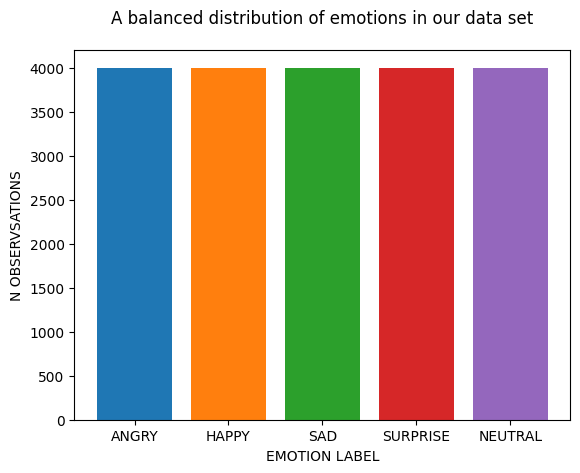

In [ ]:
# generate x labels for the plot
emotion_labels = [label_map[i] for i in label_map.keys()]

# generate counts for each emotion type
emotion_counts = [np.sum(df["emotion"] == i) for i in range(len(label_map))]

# generate a bar plot for the emotion labels that has different colors
[plt.bar(x = emotion_labels[i], height = emotion_counts[i] ) for i in range(len(emotion_labels))]

# make the plot interpretable with x and y labels + title
plt.xlabel('EMOTION LABEL')
plt.ylabel('N OBSERVSATIONS')
plt.title('A balanced distribution of emotions in the data set', y=1.05);

In [ ]:
#@title Run this code to setup the extraction of Facial Landmarks

# Load's dlib's pretrained face detector model
#frontalface_detector = dlib.get_frontal_face_detector()


#Load the 68 face Landmark file
predictor = dlib.shape_predictor('./shape_predictor_68_face_landmarks.dat')
"""
Returns facial landmarks for the given input image path
"""
def get_landmarks(image):


  #:type image : cv2 object
  #:rtype landmarks : list of tuples where each tuple represents
  #                  the x and y co-ordinates of facial keypoints

  #Bounding Box co-ordinates around the face(Training data is 48*48(cropped faces))
  rects = [dlib.rectangle(left=1, top=1, right=47, bottom=47)]

  #Read Image using OpenCV
  #image = cv2.imread(image_path)
  #Detect the Faces within the image
  landmarks = [(p.x, p.y) for p in predictor(image, rects[0]).parts()]
  return image,landmarks

"""
Display image with its Facial Landmarks
"""
def plot_image_landmarks(image,face_landmarks):
  """
  :type image_path : str
  :type face_landmarks : list of tuples where each tuple represents
                     the x and y co-ordinates of facial keypoints
  :rtype : None
  """
  radius = -2
  circle_thickness = 1
  image_copy = image.copy()
  for (x, y) in face_landmarks:
    cv2.circle(image_copy, (x, y), circle_thickness, (255,0,0), radius)

  plt.imshow(image_copy, interpolation='nearest', cmap='Greys_r')
  plt.xticks([]); plt.yticks([])
  plt.show()


'''
Converts pixels values to 2D-image.
Displays the image and returns the cv2 image
object
'''
def get_pixels_image(img_pixels,plt_flag):
  """
  :type image_pixels : str
  :type plt_flag : boolean
  :rtype image : cv2 object
  """

  width = 48
  height = 48

  image = np.fromstring(img_pixels, dtype=np.uint8, sep=" ").reshape((height, width))

  if plt_flag:
      plt.imshow(image, interpolation='nearest', cmap="Greys_r")
      plt.xticks([]); plt.yticks([])
      plt.show()


  return image


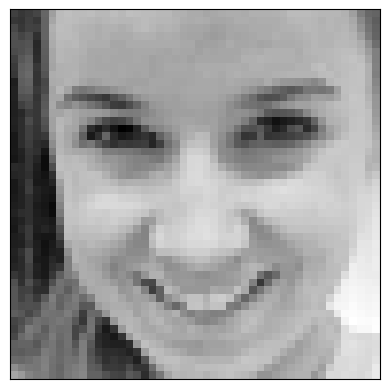

In [ ]:
# select random index
i_index = np.random.randint(len(df))

# extract pixel values
image_pixels = df['pixels'][i_index]

# convert pixels to 2D Images
image = get_pixels_image(image_pixels, True)

####Plot Facial Landmarks on the Datapoints

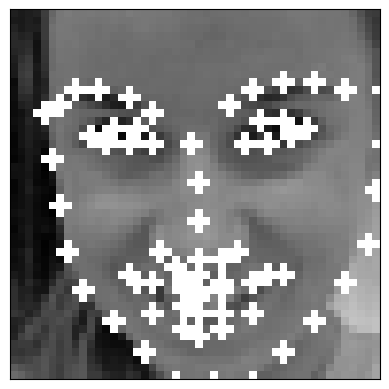

In [ ]:
#Extract the Facial Landmarks
image,facial_landmarks = get_landmarks(image)

#Display the Facial Landmarks on the Image
plot_image_landmarks(image,facial_landmarks)

###Euclidean Distance between Facial Landmarks

In [ ]:
for i, j in itertools.combinations(range(4), 2):
  print(i, j)

0 1
0 2
0 3
1 2
1 3
2 3


In [ ]:
"""
Computes euclidean distance between 68 Landmark Points for the features
e_dist is a list of features that will go into the model.
Each feature is a distance between two landmark points, and every pair of points
must have a feature.
Scipy Library has readily available fuction to compute euclidean distance. You can
compute the distance using distance.euclidean(point1,point2)
point1,point2 :2D points
"""
def get_all_landmarks_euclid_dist(face_landmarks):
  e_dist = []
  for i, j in itertools.combinations(range(68), 2):
    dist= distance.euclidean(face_landmarks[i],face_landmarks[j])
    e_dist.append(dist)

  return e_dist

print(get_all_landmarks_euclid_dist(facial_landmarks))

[6.082762530298219, 12.165525060596439, 18.24828759089466, 23.53720459187964, 28.460498941515414, 33.61547262794322, 38.91015291668744, 41.340053217188775, 44.204072210600685, 43.840620433565945, 44.204072210600685, 44.77722635447622, 45.31004303683677, 44.14748010928823, 44.181444068749045, 44.10215414239989, 2.23606797749979, 5.0, 7.615773105863909, 11.180339887498949, 14.0, 24.020824298928627, 27.16615541441225, 31.25699921617557, 35.22782990761707, 39.11521443121589, 19.4164878389476, 21.93171219946131, 24.413111231467404, 27.586228448267445, 23.430749027719962, 26.248809496813376, 29.0, 29.832867780352597, 30.805843601498726, 6.708203932499369, 9.219544457292887, 12.165525060596439, 14.560219778561036, 11.704699910719626, 8.94427190999916, 26.30589287593181, 28.0178514522438, 31.016124838541646, 34.058772731852805, 32.14031735997639, 29.274562336608895, 23.706539182259394, 26.076809620810597, 28.42534080710379, 30.479501308256342, 31.827660925679098, 34.828149534535996, 37.4432904

In [ ]:
#@title Function that preprocesses the data to extract distances between all points

def preprocess_data(df):

  X = []
  Y = []
  X_pixels = []

  n_pixels = 2304

  for index, row in (df.iterrows()):

      if index%1000 == 0:
        print (index, "Datapoints Processed")

      try:
          image = get_pixels_image(row['pixels'],0)
          X_pixels.append(image.ravel())
          image = cv2.GaussianBlur(image,(5,5),0)

          _,face_landmarks = get_landmarks(image)
          X.append(get_all_landmarks_euclid_dist(face_landmarks)) # Using the feature function
          Y.append(row['emotion'])

      except Exception as e:
          print ("An error occured:",e)

  #Save the data
  np.save("pureX", X_pixels)
  np.save("dataX", X)
  np.save("dataY", Y)

  return np.array(X_pixels),np.array(X),np.array(Y)

###Load the Saved Data

In [ ]:
# set to True if we want to preload data -- which has already been generated for us :)
preload = True

if preload:

  # load outputs saved in this folder after running preprocess_data()
  dataX = np.load('./dataX.npy')
  dataY = np.load('./dataY.npy', allow_pickle=True)

else:

  # this takes 15-20 minutes to run, but someone has already run it and saved the ouputs in this folder
  pureX, dataX, dataY = preprocess_data(df)

###Split the data



In [ ]:
#Split Data into Train, Test (90-10)
X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=0.1, random_state=42,stratify =dataY)

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train,y_train)
model.score(X_test,y_test)

0.493

In [ ]:
####Standardize the data####################

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X_train.shape

(18000, 2278)

###Train the model

In [ ]:

'''lr = LogisticRegression(solver='lbfgs',multi_class='multinomial')
lr.fit(X_train, y_train)
lr.score(X_test, y_test)'''

'''knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)'''
# highest 0.4825

dt = DecisionTreeClassifier(max_depth=15)
dt.fit(X_train, y_train)
dt.score(X_test, y_test)
#highest 0.48ish


0.4415

###Evaluate the model

In [ ]:
'''
Plots the confusion Matrix and saves it
Pass the true labels and the predicted labels
'''
def plot_confusion_matrix(y_true,y_predicted):
  cm = metrics.confusion_matrix(y_true, y_predicted)
  print ("Plotting the Confusion Matrix")
  labels = list(label_map.values())
  df_cm = pd.DataFrame(cm,index = labels,columns = labels)
  fig = plt.figure()
  res = sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')
  plt.yticks([0.5,1.5,2.5,3.5,4.5], labels,va='center')
  plt.title('Confusion Matrix - TestData')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()
  plt.close()

Plotting the Confusion Matrix


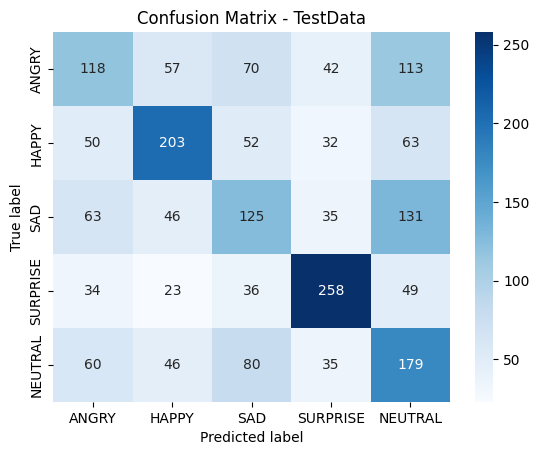

In [ ]:
plot_confusion_matrix(
        y_test,
        dt.predict(X_test)
        )

In [ ]:
#Load the true pixel data and corresponding labels
X = np.load('pureX.npy')
Y = np.load('dataY.npy')

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42,stratify =Y)
lr = LogisticRegression(solver='lbfgs',multi_class='multinomial')

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

lr.fit(X_train,y_train)
lr.score(X_test,y_test)

0.401

#Finish!